<a href="https://colab.research.google.com/github/woaixuexi2023/D2L--Module2--HW1/blob/main/GAN(keras)_to_generate_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown

In [2]:
#Use mountain drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Navigate the direction where the file located
%cd /content/drive/MyDrive/Cats/cats

/content/drive/MyDrive/Cats/cats


In [4]:
#check the file 
!ls

CAT_00	CAT_06			 generated_img_000_5.png
CAT_01	generated_img_000_0.png  generated_img_000_6.png
CAT_02	generated_img_000_1.png  generated_img_000_7.png
CAT_03	generated_img_000_2.png  generated_img_000_8.png
CAT_04	generated_img_000_3.png  generated_img_000_9.png
CAT_05	generated_img_000_4.png


In [5]:
dataset_path = '../cats'

In [6]:
dataset = keras.utils.image_dataset_from_directory(
    dataset_path, label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)#9997 files

Found 10007 files belonging to 1 classes.


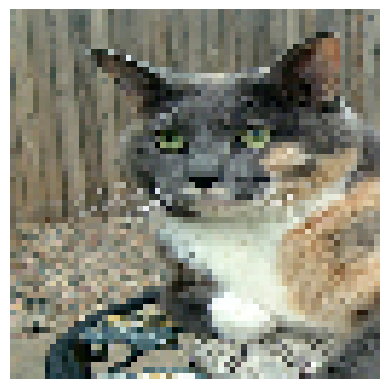

In [7]:
#Display a sample image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [8]:
#Discriminator model
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [9]:
#Generator model
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [10]:
#train step
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [11]:
#Create a callback that periodically saves generated images
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [23]:
#train the model
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100
313/313 [==============================] - 16s 37ms/step - d_loss: 0.6566 - g_loss: 1.1930
Epoch 2/100
313/313 [==============================] - 13s 39ms/step - d_loss: 0.6989 - g_loss: 1.3677
Epoch 3/100
313/313 [==============================] - 13s 39ms/step - d_loss: 0.7052 - g_loss: 1.2057
Epoch 4/100
313/313 [==============================] - 12s 38ms/step - d_loss: 0.6295 - g_loss: 1.1567
Epoch 5/100
313/313 [==============================] - 13s 39ms/step - d_loss: 0.5784 - g_loss: 1.4222
Epoch 6/100
313/313 [==============================] - 13s 40ms/step - d_loss: 0.7055 - g_loss: 1.4694
Epoch 7/100
313/313 [==============================] - 13s 39ms/step - d_loss: 0.6370 - g_loss: 1.1630
Epoch 8/100
313/313 [==============================] - 13s 40ms/step - d_loss: 0.7662 - g_loss: 1.5833
Epoch 9/100
313/313 [==============================] - 13s 39ms/step - d_loss: 0.6176 - g_loss: 1.0486
Epoch 10/100
313/313 [==============================] - 13s 39ms/step - d

In [24]:
import os

# List all files in the current directory
files = os.listdir('../cats')

# Filter for image files with the "png" extension
image_files = [f for f in files if f.endswith(".png")]

# Print the filenames
print(image_files)


['generated_img_000_0.png', 'generated_img_000_1.png', 'generated_img_000_2.png', 'generated_img_000_3.png', 'generated_img_000_4.png', 'generated_img_000_5.png', 'generated_img_000_6.png', 'generated_img_000_7.png', 'generated_img_000_8.png', 'generated_img_000_9.png', 'generated_img_001_0.png', 'generated_img_001_1.png', 'generated_img_001_2.png', 'generated_img_001_3.png', 'generated_img_001_4.png', 'generated_img_001_5.png', 'generated_img_001_6.png', 'generated_img_001_7.png', 'generated_img_001_8.png', 'generated_img_001_9.png', 'generated_img_002_0.png', 'generated_img_002_1.png', 'generated_img_002_2.png', 'generated_img_002_3.png', 'generated_img_002_4.png', 'generated_img_002_5.png', 'generated_img_002_6.png', 'generated_img_002_7.png', 'generated_img_002_8.png', 'generated_img_002_9.png', 'generated_img_003_0.png', 'generated_img_003_1.png', 'generated_img_003_2.png', 'generated_img_003_3.png', 'generated_img_003_4.png', 'generated_img_003_5.png', 'generated_img_003_6.png', 

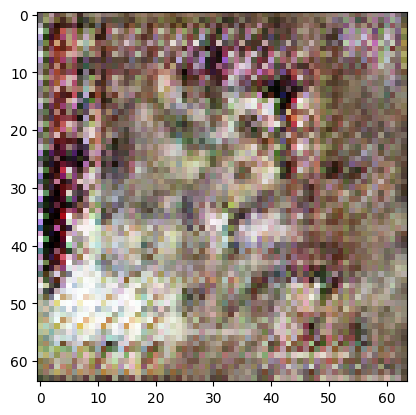

In [25]:
import matplotlib.pyplot as plt

# Load the generated image
img = plt.imread('generated_img_099_9.png')

# Show the image
plt.imshow(img)
plt.show()
